In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import moleculetools as mt
import seaborn as sns
import plot_utils as pu
import re

%matplotlib inline

pu.set_styles()

In [11]:
class System:
    def __init__(self, *args, **kwargs):
        self.name = kwargs.get('name', "system")
        self.ints = {}
        print("System instantiated!\n")
        
    def get_wn(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.wn = []
        for i in range(len(lines)):
            line = lines[i]
            if "Frequencies --" in line:
                self.wn += [float(x) for x in line.split()[2:]]
            else:
                pass
        
    def load_raman(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.ints['SL'] = []
        for i in range(len(lines)):
            line = lines[i]
            if "Raman Activ --" in line:
                self.ints['SL'] += [float(x) for x in line.split()[3:]]
            else:
                pass
    
    def load_uv(self, filename):
        with open(filename, 'r') as openfile:
            full = openfile.read()
            lines = openfile.readlines()
        
        nstates = re.search(r'(?<=nstates\=)\d+', full).group(0)
        states = re.findall(r'(?<=Excited State).*(?=\<\S\*\*2\>)', full)
        self.uv_data = {}
        for state in states:
            state_n = int(state.split()[0].split(':')[0])
            nm = float(state.split()[4])
            f = float(state.split()[6].split('=')[-1])
            self.uv_data[state_n] = {}
            self.uv_data[state_n]['nm'] = nm
            self.uv_data[state_n]['f'] = f
        
            
    def plot_raman(self, modes=[], xlim='auto'):
        f, ax = pu.new_figure(height=5, type='body')
        
        margin = (max(self.wn) - min(self.wn))*0.05
        if xlim == 'auto':
            xmin = np.where(min(self.wn) - margin >= 0, min(self.wn) - margin, 0)
            xmin = np.floor(xmin/100)*100
            xmax = np.where(max(self.wn) + margin >= 0, max(self.wn) + margin, 0)
            xmax = np.ceil(xmax/100)*100
            xlim = [xmin, xmax]
        ax.set_xlim(xlim)
        ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')
        
        points, gaussians = calculate_envelope(x=self.wn, y=self.ints['SL'], preexp=1, sigma=8)
        sns.lineplot(points, gaussians.sum(axis=0), ax=ax)        
        pu.tuftefy(ax)

        for mode in modes:
            ax.axvline(x=self.wn[mode - 1], ymin=0, ymax=1)
            ax.text(x=self.wn[mode - 1] + ax.get_xlim()[1]*0.005, y=ax.get_ylim()[1]*0.95, s=str(mode))
            
        return f, ax
    

def plot_uv(system=None, xlim='auto', states_to_plot=None):
    f, ax = pu.new_figure(height=5, type='body')

    all_nm = [system.uv_data[state]['nm'] for state in system.uv_data.keys()]
    all_f = [system.uv_data[state]['f'] for state in system.uv_data.keys()]

    margin = (max(all_nm) - min(all_nm))*0.05
    if xlim == 'auto':
        xmin = np.where(min(all_nm) - margin >= 0, min(all_nm) - margin, 0)
        xmin = np.floor(xmin/50)*50
        xmax = np.where(max(all_nm) + margin >= 0, max(all_nm) + margin, 0)
        xmax = np.ceil(xmax/50)*50
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'Wavelength (nm)')

    uv_preexp = 40489.9942104
    uv_sigma = 0.000322622
    all_nm = [1/nm for nm in all_nm]
    points, gaussians = calculate_envelope(x=all_nm,
                                           y=all_f,
                                           preexp=uv_preexp,
                                           sigma=uv_sigma,
                                           xrange=[100, 300],
                                           inverse=True)
    sns.lineplot(points, gaussians.sum(axis=0), ax=ax)
    pu.tuftefy(ax)
    return f, ax
       

def calculate_envelope(x, y, npoints=10000, preexp=1, sigma=1, xrange=[0, 4000], inverse=False):
    xspace = np.linspace(xrange[0], xrange[1], npoints)
    points = xspace
    if inverse == True:
        points = points**(-1)
    gaussians = []
    for pair in list(zip(x, y)):
        gaussians.append(pair[1]*preexp*np.exp(-np.square((points - pair[0])/sigma)))
    return xspace, np.array(gaussians)

def load_system(nameid):
    system = System(name=nameid)
    system.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    return system

In [13]:
s08 = load_system('s08')

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.


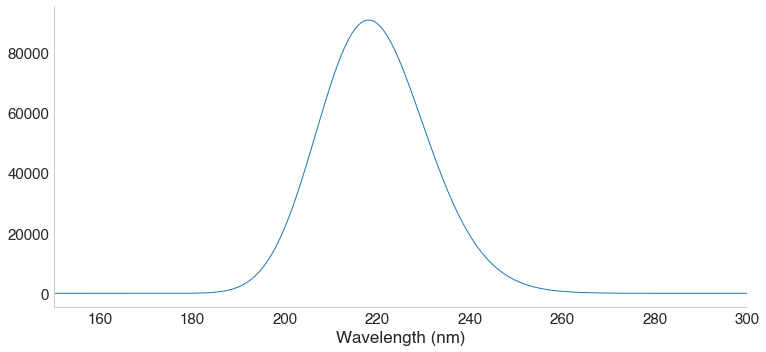

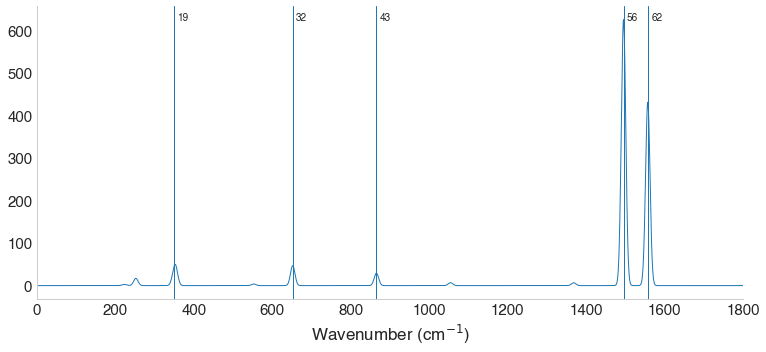

In [16]:
plot_uv(system=s08)
f, ax = s08.plot_raman(modes=[19, 32, 43, 56, 62])